In [1]:
%cd /home/smalani/controlledLearning
import khammash_repro
import matplotlib.pyplot as plt
import numpy as np

/home/smalani/controlledLearning


/home/smalani/.conda/envs/torch-env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import train_model
train_model.main()

Train/Loss: 2.54e-07  Val/Loss: 2.90e-07: 100%|██████████| 2000/2000 [18:25<00:00,  1.81it/s]


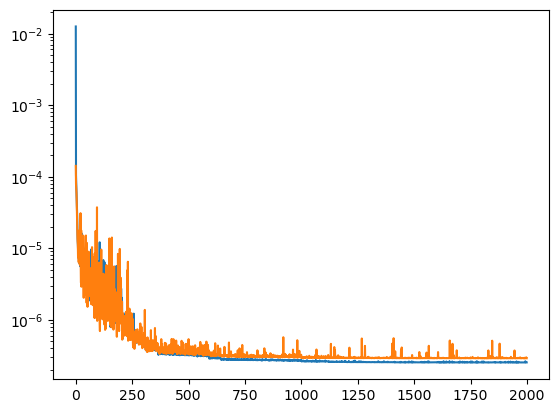

In [3]:
import matplotlib.pyplot as plt

epoch_arr = np.load('epoch_arr.npy')
epoch_train_loss = np.load('epoch_train_loss.npy')
epoch_val_loss = np.load('epoch_val_loss.npy')

plt.semilogy(epoch_arr, epoch_train_loss, label='Training Loss')
plt.semilogy(epoch_arr, epoch_val_loss, label='Validation Loss')

In [4]:
import utils
import torch 

network = utils.MLP(14, [100, 100, 100], 7)
network = utils.Network(network, x_norm=[0, 1], p_norm=[0, 800])
network = network.float()

network.load_state_dict(torch.load('network.net'))

<All keys matched successfully>

In [7]:
phi, L = khammash_repro.datagen(n_traj=1, sp_per_traj=5)
phi = phi[0]
L = L[0]

phi_pred = np.zeros((phi.shape))
phi_pred[:7] = phi[:7]

for i in range(0, len(phi)-7):
    phi_in = torch.tensor([phi_pred[i:i+7]]).float()
    L_in = torch.tensor([L[i:i+7]]).float()
    phi_out = network(phi_in, L_in)
    phi_pred[i+7] = phi_out.detach().squeeze().numpy()[-1]

100%|██████████| 1/1 [00:11<00:00, 11.44s/it]
/tmp/ipykernel_963367/597653434.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  phi_in = torch.tensor([phi[i:i+7]]).float()


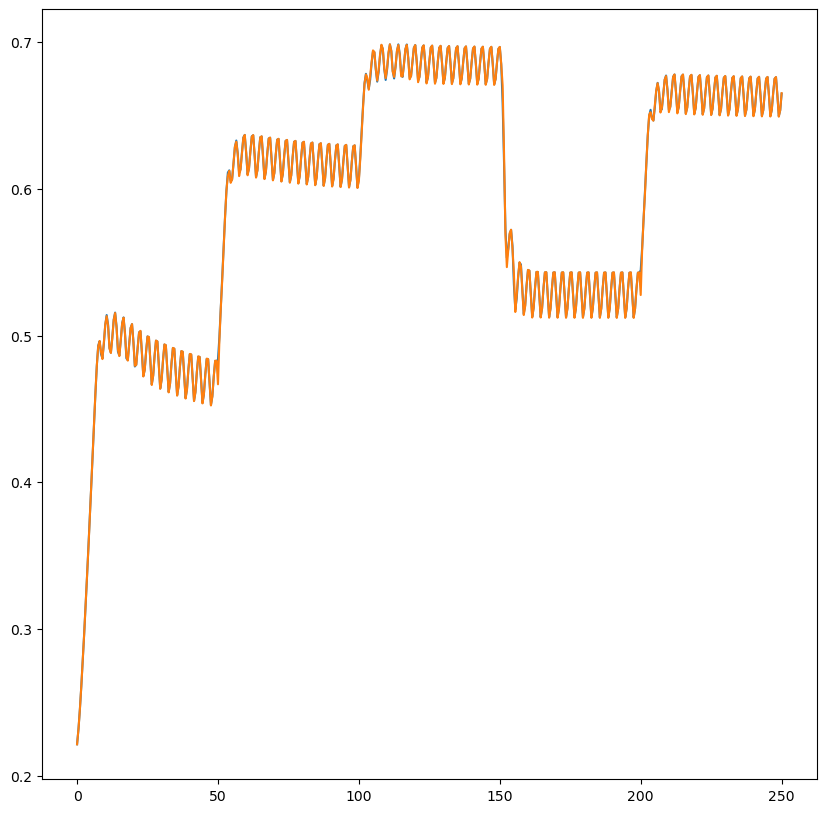

In [9]:
fig = plt.figure(figsize=(10, 10))

t = np.arange(0, len(phi)) / 2

ax = fig.add_subplot(111)
ax.plot(t, phi, label='True')
ax.plot(t, phi_pred, label='Predicted')

In [ ]:
def fsolve_pid(x, phi, L, sp, L0, sampling_time):
    Kp, Ki, Kd, Kbc = x

    L_out = np.zeros(L.shape)

    u0 = L0/800
    error_accum = 0
    error_old = 0
    for i in range(phi.size):
        error = sp[i] - phi[i]
        error_accum += error * sampling_time
        u_compute = u0 + Kp * error + Kd * (error - error_old)/sampling_time + Ki * error_accum
        u = np.clip(u_compute, 0, 1)
        bc = u - u_compute
        error_accum = error_accum + bc * Ki * Kbc
        error_old = error
        L_out[i] = u*800

    return np.average((L_out - L) ** 2)